In [16]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device = get_device()
set_seed(42)
print("Using device:", device)

Using device: mps


In [3]:
database = "MNIST-full"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # if it's not
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # standard MNIST normalization
])

train_full = datasets.ImageFolder(os.path.join(database, "train"), transform=transform)
test_set = datasets.ImageFolder(os.path.join(database, "test"), transform=transform)

print("Train size:", len(train_full))
print("Test size:", len(test_set))
print("Classes:", train_full.classes)

Train size: 60000
Test size: 10000
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
# Train split
val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_full))
val_size = len(train_full) - train_size

train_set, val_set = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

print("Train size:", len(train_set))
print("Val size:", len(val_set))
print("Test size:", len(test_set))
# just for check
images, labels = next(iter(train_loader))
print("\nBatch:", images.shape, labels.shape), "| first labels:", labels[:8].tolist()

Train size: 54000
Val size: 6000
Test size: 10000

Batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


(None, '| first labels:', [9, 1, 1, 6, 8, 7, 7, 5])

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden1=128, hidden2=64, num_classes=10, dropout_p=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # [B,1, 28, 28] -> [B,784]
        return self.model(x)

In [10]:
def train_model(model, train_loader, val_loader, lr=0.009, epochs=30, patience=5, weight_decay=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        # train
        model.train()
        t_loss = 0.0
        t_correct = 0
        t_total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_correct += (outputs.argmax(1) == y).sum().item()
            t_total += y.size(0)
        tr_loss = t_loss / len(train_loader)
        tr_acc = t_correct / t_total

        # val
        model.eval()
        v_loss = 0.0
        v_correct = 0
        v_total = 0

        with torch.inference_mode():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                v_loss += loss.item()
                v_correct += (outputs.argmax(1) == y).sum().item()
                v_total += y.size(0)
        val_loss = v_loss / len(val_loader)
        val_acc = v_correct / v_total

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1:02d}: TrainLoss={tr_loss:.4f}, ValLoss={val_loss:.4f}, TrainAcc={tr_acc:.3f}, ValAcc={val_acc:.3f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early Stopping triggered!")
                break

    # restore the best model after early stopping
    if best_state is not None:
        model.load_state_dict(best_state)

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_state": best_state,
        "best_val_loss": best_val_loss,
        "best_val_acc": max(val_accs) if val_accs else 0.0
    }

Epoch 01: TrainLoss=0.4300, ValLoss=0.1702, TrainAcc=0.868, ValAcc=0.948
Epoch 02: TrainLoss=0.1857, ValLoss=0.1297, TrainAcc=0.946, ValAcc=0.962
Epoch 03: TrainLoss=0.1432, ValLoss=0.1080, TrainAcc=0.957, ValAcc=0.969
Epoch 04: TrainLoss=0.1192, ValLoss=0.0973, TrainAcc=0.964, ValAcc=0.971
Epoch 05: TrainLoss=0.1036, ValLoss=0.0873, TrainAcc=0.969, ValAcc=0.975
Epoch 06: TrainLoss=0.0928, ValLoss=0.0890, TrainAcc=0.971, ValAcc=0.974
Epoch 07: TrainLoss=0.0837, ValLoss=0.0812, TrainAcc=0.974, ValAcc=0.976
Epoch 08: TrainLoss=0.0799, ValLoss=0.0824, TrainAcc=0.975, ValAcc=0.976
Epoch 09: TrainLoss=0.0719, ValLoss=0.0830, TrainAcc=0.978, ValAcc=0.974
Epoch 10: TrainLoss=0.0677, ValLoss=0.0770, TrainAcc=0.979, ValAcc=0.977
Epoch 11: TrainLoss=0.0620, ValLoss=0.0771, TrainAcc=0.980, ValAcc=0.978
Epoch 12: TrainLoss=0.0621, ValLoss=0.0746, TrainAcc=0.980, ValAcc=0.979
Epoch 13: TrainLoss=0.0576, ValLoss=0.0755, TrainAcc=0.981, ValAcc=0.980
Epoch 14: TrainLoss=0.0545, ValLoss=0.0709, TrainAc

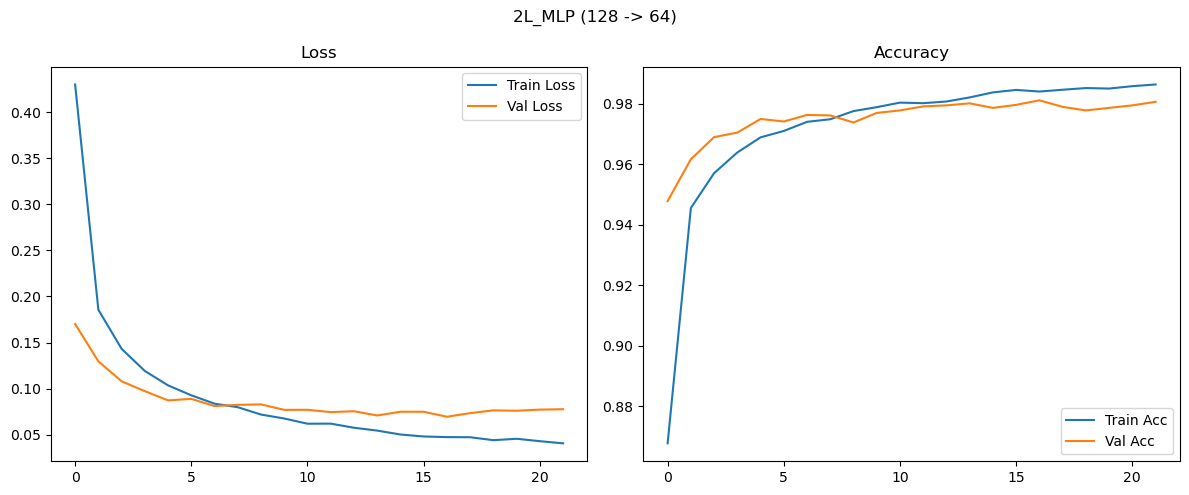

Best Val Acc: 0.9811666666666666


In [11]:
def plot_curves(hist, title=None):
    trL, valL = hist["train_losses"], hist["val_losses"]
    trA, valA = hist["train_accs"], hist["val_accs"]
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1); plt.plot(trL, label="Train Loss"); plt.plot(valL, label="Val Loss"); plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2); plt.plot(trA, label="Train Acc"); plt.plot(valA, label="Val Acc"); plt.legend(); plt.title("Accuracy")

    if title: plt.suptitle(title)
    plt.tight_layout(); plt.show()

model = MLP(hidden1=128, hidden2=64, dropout_p=0.2).to(device)

history = train_model(
    model,
    train_loader,
    val_loader,
    lr=0.009,
    epochs=30,
    patience=5,
    weight_decay=1e-4
)

plot_curves(history, title="2L_MLP (128 -> 64)")
print("Best Val Acc:", history["best_val_acc"])

In [15]:
# Evaluate on the test set
model.eval()
correct = 0
total = 0
test_loss = 0.0
criterion = nn.CrossEntropyLoss()

with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()

        preds = outputs.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

# average loss and accuracy
test_loss /= len(test_loader)
test_acc = correct / total

print(f"Test Accuracy: {test_acc:.3f}")
print(f"Average Test Loss: {test_loss:.3f}")

Test Accuracy: 0.980
Average Test Loss: 0.066


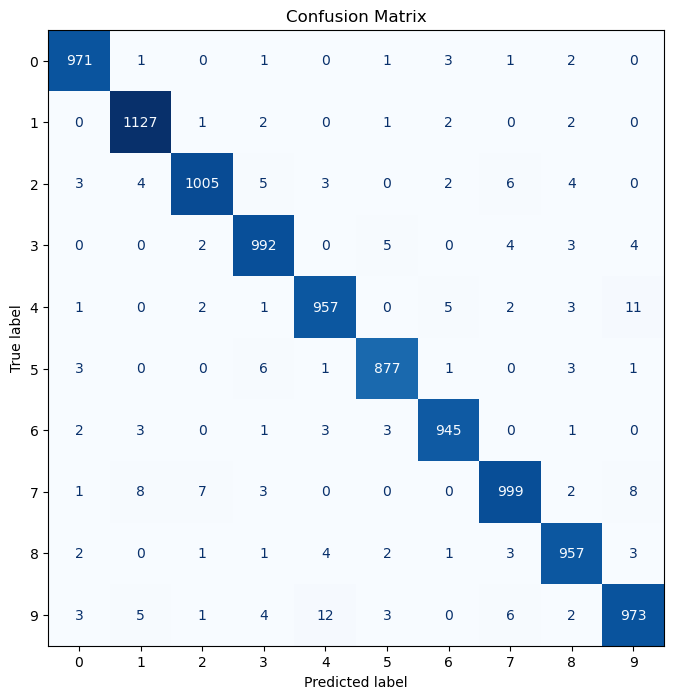

In [21]:
all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])

plt.figure(figsize=(8, 8))
display_cm.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix")
plt.show()